## Do Transformers Learn Linear Models?

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir("..")

In [4]:
import torch
from slalom_explanations.transformer_models import DistilBert, GPT2, Bert, Trainer

In [5]:
from transformers import AutoTokenizer

To run this notebooks, first train the models using the script
```
./train_models_linear.sh
```
Then update the following path to the one where the models where saved by the script.

In [8]:
binomial = True
prefix = "/mnt/ssd3/tobias/models_lin_bin_rerun"

In [9]:
def compute_logits_for_single_token(tokenizer, model, n_max=10, use_cls=True, input_str="perfect", neutral_input="the", use_device="cuda:2"):
    logit_results = []
    cls_tok = torch.tensor([101])
    input_tok = torch.tensor(tokenizer.convert_tokens_to_ids(input_str)).reshape(1)
    neutal_tok = torch.tensor(tokenizer.convert_tokens_to_ids(neutral_input)).reshape(1)
    sep_tok = torch.tensor([102])
    ## Evaluate neutral input
    if use_cls:
        input = torch.cat((cls_tok, neutal_tok, sep_tok))
    else:
        input = neutal_tok
    with torch.no_grad():
        logit_score = model(input.reshape(1,-1).to(use_device))["logits"]
        logit_results.append(logit_score.detach().cpu())
        
        x = input_tok
        for i in range(n_max):
            #print(x)
            if use_cls:
                input = torch.cat((cls_tok, x, sep_tok))
            else:
                input = x
            logit_score = model(input.reshape(1,-1).to(use_device))["logits"]
            logit_results.append(logit_score.detach().cpu())
            x = torch.cat((x, input_tok), dim=0)
    return torch.stack(logit_results)
    

In [41]:
n_heads = 12
device = "cuda:2"
res_dict = {}
for model in ["bert", "distilbert", "gpt2"]:
    res_dict[model] = {}
    for n_layers in [1, 2, 4, 8, 12]:
        if "gpt2" in model:
            model_obj = GPT2(n_layer=n_layers, n_head=n_heads, pretrained=False)
            tokenizer = AutoTokenizer.from_pretrained('distilgpt2', use_fast=True)
        else:
            if model == "bert":
                model_obj = Bert(n_layers=n_layers, n_heads=n_heads, pretrained=False)
            else:
                model_obj = DistilBert(n_layers=n_layers, n_heads=n_heads, pretrained=False)
            tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
        model_str = f"{prefix}/sparsebow_{model}_{n_layers}_r0.pt"
        model_obj.model.load_state_dict(torch.load(model_str))
        model_obj.model.eval()
        model_obj.model = model_obj.model.to(device)
        ## Now run forward passes
        res = compute_logits_for_single_token(tokenizer, model_obj.model, n_max=30, use_cls="bert" in model)
        res = res[:,:,1]-res[:,:,0]
        res_dict[model][n_layers] = res 
        print(model, n_layers)  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for an

bert 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert 4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert 8


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert 12
distilbert 1
distilbert 2
distilbert 4
distilbert 8
distilbert 12
gpt2 1
gpt2 2
gpt2 4
gpt2 8
gpt2 12


## The linear model

In [17]:
from slalom_explanations.bow_dataset import SparseBoWDataset

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)

words_dict = {"the": (0.2, 0.0), "we": (0.2, 0.0), "movie": (0.2, 0.0), "watch": (0.2, 0.0),
      "best": (0.06, 1.0), "perfect": (0.06, 1.5), "good": (0.08, 0.7),
      "worst": (0.06, -1.5), "poor": (0.06, -1.0),"ok": (0.08, -0.7)}
myds = SparseBoWDataset(tokenizer, all_words_dict =  words_dict, fixed_len=False, binomial_sampling=binomial)

from torch.utils.data import DataLoader
mydl = DataLoader(myds, batch_size=32)

In [29]:
use_device="cuda"
n_layers, n_heads, model = 2, 12, "distilbert"
model_str = f"{prefix}/sparsebow_{model}_{n_layers}_r0.pt"
model_obj = DistilBert(n_layers=n_layers, n_heads=n_heads, pretrained=False)
model_obj.model.load_state_dict(torch.load(model_str))
model_obj.model.to(use_device)
print("Loaded model for embeddings.")

import torch.nn as nn
class TwoLayerFixedContext(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        return self.layer2(x)

from torch.optim import Adam
def fit_sgd(my_dl, model, num_eps=10, lr=5e-4, batch_size=32):
    model = model.to(use_device)
    my_optim = Adam(model.parameters(), lr = lr)
    losses = []
    iters = 0
    loss_fn = nn.CrossEntropyLoss()
    for ep in range(num_eps):
        losses = []
        for batch in my_dl:
            my_optim.zero_grad()
            #output = example_model.forward(batch["input_ids"])
            #loss = myloss(output, batch["label"])
            input_embs = model_obj.model.distilbert.embeddings.word_embeddings(batch["input_ids"].to(use_device)).detach().clone()
            #print(input_embs.shape)
            output = model.forward(input_embs.reshape(len(input_embs), -1))
            loss = loss_fn(output, batch["label"].to(use_device))
            loss.backward()
            my_optim.step()
            losses.append(loss.item())
            iters += 1
        print(torch.tensor([losses]).mean())
    return model

def compute_logits_for_single_token_fc(model, n_max=10, use_cls=True):
    logit_results = []
    cls_tok = torch.tensor([101])
    input_tok = torch.tensor([3819])
    pad_tok = torch.tensor([1996])
    inputs_pad = torch.ones(n_max+1, 32, dtype=torch.long)*pad_tok
    if use_cls:
        x = cls_tok.reshape(1)
    else:
        x = torch.empty(0)
    
    for i in range(n_max+1):
        inputs_pad[i, :len(x)] = x
        x = torch.cat((x, input_tok), dim=0)
    inputs_pad[:,-1] = 102
    #print(inputs_pad)
    with torch.no_grad():
        input_embs =  model_obj.model.distilbert.embeddings.word_embeddings(inputs_pad.to(use_device)).detach().clone()
        logit_score = model.forward(input_embs.reshape(len(input_embs), -1))
        score = logit_score[:,1]-logit_score[:,0]
    return score

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loaded model for embeddings.


In [40]:
out_dict_lin = {}
### The linear model
for hidden_sz in [200, 400, 1000]:
    fc_model = TwoLayerFixedContext(32*768, hidden_sz)
    fc_model = fit_sgd(mydl, fc_model, num_eps=6)
    out_dict_lin[hidden_sz] = compute_logits_for_single_token_fc(fc_model, n_max=30, use_cls=True)

tensor(0.5154)
tensor(0.4632)
tensor(0.4501)
tensor(0.4459)
tensor(0.4453)
tensor(0.4304)
tensor(0.5150)
tensor(0.4643)
tensor(0.4477)
tensor(0.4500)
tensor(0.4501)
tensor(0.4465)
tensor(0.5211)
tensor(0.4580)
tensor(0.4545)
tensor(0.4454)
tensor(0.4369)
tensor(0.4462)


In [31]:
out_dict_lin

{200: tensor([-1.3849e+00, -3.8673e-04,  1.4164e+00,  2.8602e+00,  3.9250e+00,
          4.9658e+00,  5.8350e+00,  6.5696e+00,  7.4953e+00,  8.1798e+00,
          8.7979e+00,  9.5492e+00,  1.0122e+01,  1.1019e+01,  1.1624e+01,
          1.2464e+01,  1.3162e+01,  1.3928e+01,  1.4538e+01,  1.5038e+01,
          1.5448e+01,  1.5905e+01,  1.6162e+01,  1.6659e+01,  1.6706e+01,
          1.6667e+01,  1.6760e+01,  1.6759e+01,  1.6758e+01,  1.6760e+01,
          1.6760e+01], device='cuda:0'),
 400: tensor([ 0.4971,  1.3989,  2.6428,  3.5735,  4.3237,  5.1338,  5.9549,  6.6935,
          7.4621,  8.0195,  8.8855,  9.6535, 10.7033, 11.0545, 11.7830, 12.4331,
         13.3343, 14.1061, 14.7809, 15.4417, 15.8634, 16.1046, 16.5599, 16.6327,
         16.7244, 16.9085, 16.8877, 16.8892, 16.8890, 16.8880, 16.8894],
        device='cuda:0'),
 1000: tensor([ 1.4410,  2.4681,  3.1613,  3.9919,  4.6072,  5.2904,  6.1336,  6.7200,
          7.5939,  8.1677,  8.8661,  9.9040, 10.6139, 11.2105, 12.3008, 13.2

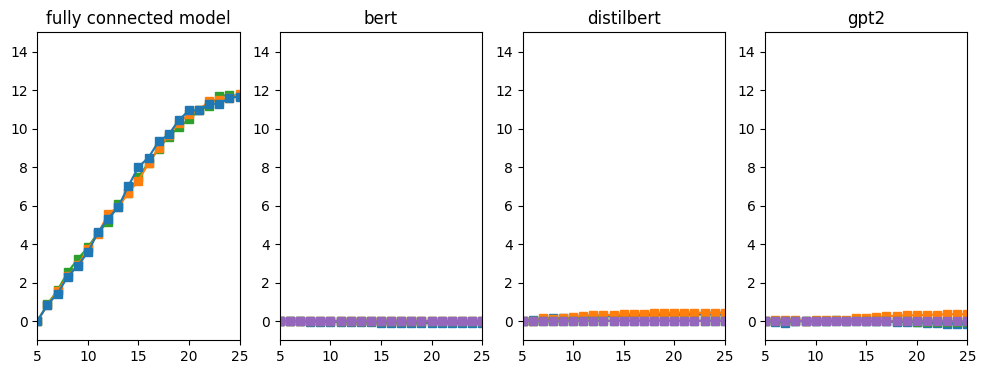

In [33]:
import matplotlib.pyplot as plt
f, ax_list = plt.subplots(1,4)
layers_col = {1: "tab:blue", 2: "tab:orange", 6:"tab:green", 8: "tab:brown", 12: "tab:purple"}
hidden_col = {1000: "tab:blue", 400: "tab:orange", 200:"tab:green"}
ax_list[0].set_title("fully connected model")
for key, value in out_dict_lin.items():
    ax_list[0].plot(value.detach().cpu()-value[5].item(), "-s", c=hidden_col[key])
    ax_list[0].set_xlim([5, 25])
    ax_list[0].set_ylim([-1, 15])
for i, model in enumerate(["bert", "distilbert", "gpt2"]):
    ax_list[i+1].set_title(model)
    for key, value in res_dict[model].items():
        norm_const = value[1:].mean()
        ax_list[i+1].plot(value-value[5], "-s", c=layers_col[key])
        ax_list[i+1].set_xlim([5, 25])
        ax_list[i+1].set_ylim([-1, 15])
f.set_size_inches(12, 4)

In [35]:
plt.style.use('./figures/matplot.mplstyle')

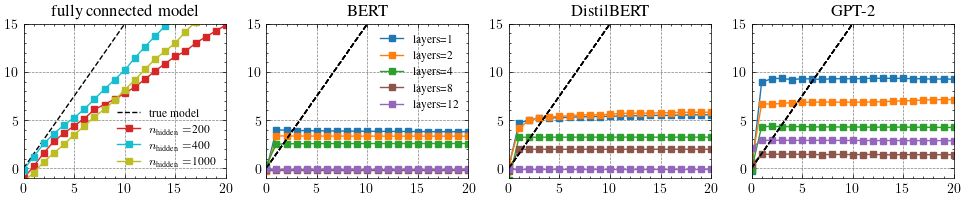

In [42]:
import matplotlib.pyplot as plt
import numpy as np
transformer_plot_keys = {"bert": "BERT", "distilbert": "DistilBERT", "gpt2": "GPT-2"}
f, ax_list = plt.subplots(1,4)
layers_col = {1: "tab:blue", 2: "tab:orange", 4:"tab:green", 8: "tab:brown", 12: "tab:purple"}
hidden_col = {200: "tab:red", 1000: "tab:olive", 400:"tab:cyan"}
ax_list[0].set_title("fully connected model")
ax_list[0].plot(np.arange(21)*1.5, "--k", label="true model")
for key, value in out_dict_lin.items():
    ax_list[0].plot(value.detach().cpu(), "-s", c=hidden_col[key], markersize=5, label=r"$n_{\text{hidden}}=$"+str(key))
ax_list[0].set_xlim([0, 20])

ax_list[0].set_ylim([-1, 15])
ax_list[0].legend(fontsize="small")
for i, model in enumerate(["bert", "distilbert", "gpt2"]):
    ax_list[i+1].set_title(transformer_plot_keys[model])
    for key, value in res_dict[model].items():
        norm_const = value[1:].mean()
        ax_list[i+1].plot(value, "-s", c=layers_col[key], markersize=5, label=r"layers="+str(key))
        ax_list[i+1].set_xlim([0, 20])
        ax_list[i+1].set_ylim([-1, 15])
        ax_list[i+1].plot(np.arange(21)*1.5, "--k")
ax_list[1].legend(fontsize="small") # Only first figure has a legend
f.set_size_inches(12, 2)

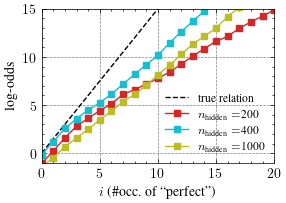

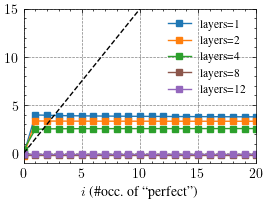

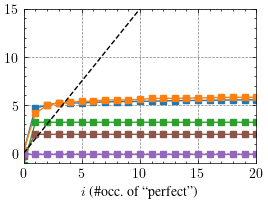

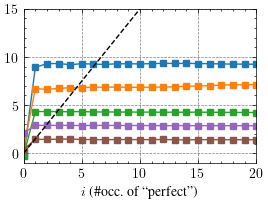

In [44]:
## Save each as one figure
import matplotlib.pyplot as plt
import numpy as np
transformer_plot_keys = {"bert": "BERT", "distilbert": "DistilBERT", "gpt2": "GPT-2"}
layers_col = {1: "tab:blue", 2: "tab:orange", 4:"tab:green", 8: "tab:brown", 12: "tab:purple"}
hidden_col = {200: "tab:red", 1000: "tab:olive", 400:"tab:cyan"}
key_list = list(transformer_plot_keys.keys())
for i in range(4):
    f, ax = plt.subplots()
    if i == 0:
        ax.plot(np.arange(21)*1.5, "--k", label="true relation")
        for key, value in out_dict_lin.items():
            ax.plot(value.detach().cpu(), "-s", c=hidden_col[key], markersize=5, label=r"$n_{\text{hidden}}=$"+str(key))
        ax.set_ylabel("log-odds")
    else: 
        model = key_list[i-1]
        for key, value in res_dict[model].items():
            ax.plot(value, "-s", c=layers_col[key], markersize=5, label=r"layers="+str(key))
        ax.set_xlim([0, 20])
        ax.set_ylim([-1, 15])
        ax.plot(np.arange(21)*1.5, "--k")
    ax.set_xlim([0, 20])
    ax.set_ylim([-1, 15])
    ax.set_xlabel(r"$i$ (\#occ. of ``perfect'')")
    if i < 2:
        ax.legend(fontsize="small") # Only first two figures have a legend
    f.set_size_inches(3, 2)
    f.savefig(f"figures/B{i}.pdf")
    #plt.tight_layout()

In [18]:
device="cuda:2"
prefix = "/mnt/ssd3/tobias/models_lin_bin_rerun"
for model in ["bert"]:
    n_layers=4
    n_heads=12
    if "gpt2" in model:
        model_obj = GPT2(n_layer=n_layers, n_head=n_heads, pretrained=False)
        tokenizer = AutoTokenizer.from_pretrained('distilgpt2', use_fast=True)
    else:
        if model == "bert":
            model_obj = Bert(n_layers=n_layers, n_heads=n_heads, pretrained=False)
        else:
            model_obj = DistilBert(n_layers=n_layers, n_heads=n_heads, pretrained=False)
        tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
    worst_tok = tokenizer.convert_tokens_to_ids("worst")
    perfect_tok = tokenizer.convert_tokens_to_ids("perfect")
    print(worst_tok, perfect_tok)
    model_str = f"{prefix}/sparsebow_{model}_{n_layers}_r0.pt"
    model_obj.model.load_state_dict(torch.load(model_str))
    model_obj.model.eval()
    model_obj.model = model_obj.model.to(device)
    ## Now run forward passes
    inp1 = torch.tensor([101, perfect_tok, 102])
    inp2 = torch.tensor([101, perfect_tok, perfect_tok, 102])
    inp3 = torch.tensor([101, worst_tok, 102])
    inp4 = torch.tensor([101, worst_tok, worst_tok, 102])
    inp5 = torch.tensor([101, worst_tok, perfect_tok, 102])
    logit_results = []
    for inputs in [inp1, inp2, inp3, inp4, inp5]:
        logit_score = model_obj.model(inputs.reshape(1,-1).to(device))["logits"]
        logit_results.append(logit_score.detach().cpu().flatten())
    res = torch.stack(logit_results)
    res = res[:,1]-res[:,0]
    print(res)
    print(model, n_layers)  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


5409 3819


/tmp/ipykernel_2292440/2897171783.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_obj.model.load_state_dict(torch.load(model_str))


tensor([ 2.4842,  2.5272, -2.6454, -2.4774, -0.0413])
bert 4
